In [7]:
from WBT.whitebox_tools import WhiteboxTools
from PySAGA_cmd import SAGA
import rasterio
import os
import csv
import matplotlib.pyplot as plt
import numpy as np
import shutil
import math
from pathlib import Path
import time
import pandas as pd

path_to_saga_cmd_exe = r'D:\altsyplenkov\saga-9.3.2_x64\saga_cmd.exe'
saga = SAGA(path_to_saga_cmd_exe)

wbt = WhiteboxTools()

In [8]:
wbt.set_verbose_mode(False)

0

# Первичное сглаживание исходных фрагментов ЦМР:

In [9]:
original_dems = ['arcticdem32m_Lena_original', 'ASTERDEM_Belgorod_original', 'SRTM30m_Kamchatka_original']
for original_dem in original_dems:
    original_file = r'D:\altsyplenkov\cw\ch3\\' + original_dem + '.tif'
    pseudo_original_file = r'D:\altsyplenkov\cw\ch3\\' + original_dem.split('_')[0] + '_' + original_dem.split('_')[1] + '_ps.tif'
    
    with rasterio.open(original_file, 'r') as ds:
        original_dem_arr = ds.read()[0]
    
    # print(np.mean(original_dem_arr))
    
    k=0
    while k != 5:
        wbt.mean_filter(original_file, pseudo_original_file, 7, 7)
        # print(k)
        k+=1
    
    with rasterio.open(pseudo_original_file, 'r') as ds:
        denoised_dem = ds.read()[0]

    #plt.imshow(denoised_dem)
        
    print(np.mean(denoised_dem))

-1.1231563
193.60776414576085
31.649548


# Визуализация полученных поверхностей

-2.9494977
0.26153272
(105, 105)
132
227
(127, 129)
20.625
110.244896
(89, 43)


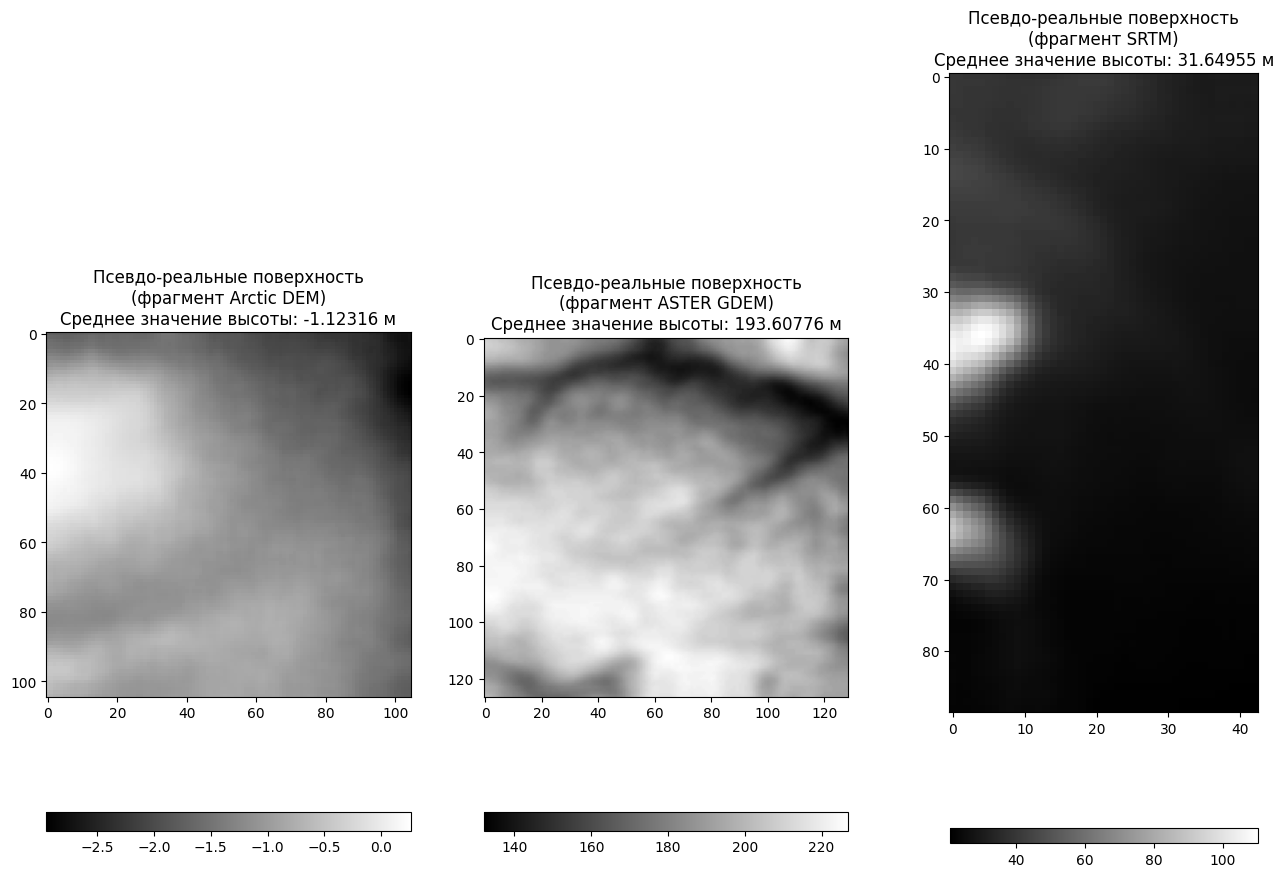

In [10]:
with rasterio.open(r'D:\altsyplenkov\cw\ch3\arcticdem32m_Lena_ps.tif') as ds:
    arct = ds.read()[0]
    print(np.min(arct))
    print(np.max(arct))
    print(arct.shape)

with rasterio.open(r'D:\altsyplenkov\cw\ch3\ASTERDEM_Belgorod_ps.tif') as ds:
    aster = ds.read()[0]
    print(np.min(aster))
    print(np.max(aster))
    print(aster.shape)

with rasterio.open(r'D:\altsyplenkov\cw\ch3\SRTM30m_Kamchatka_ps.tif') as ds:
    srtm = ds.read()[0]
    print(np.min(srtm))
    print(np.max(srtm))
    print(srtm.shape)

fig = plt.figure(figsize=(16, 10))

ax1 = fig.add_subplot(1, 3, 1)
ax1.set_title(f'Псевдо-реальные поверхность\n(фрагмент Arctic DEM)\nСреднее значение высоты: {round(float(np.mean(arct)), 5)} м')
plt.imshow(arct, cmap='binary_r')
plt.colorbar(fraction=0.04, orientation='horizontal')

ax2 = fig.add_subplot(1, 3, 2)
ax2.set_title(f'Псевдо-реальные поверхность\n(фрагмент ASTER GDEM)\nСреднее значение высоты: {round(float(np.mean(aster)), 5)} м')
plt.imshow(aster, cmap='binary_r')
plt.colorbar(fraction=0.04, orientation='horizontal')

ax3 = fig.add_subplot(1, 3, 3)
ax3.set_title(f'Псевдо-реальные поверхность\n(фрагмент SRTM)\nСреднее значение высоты: {round(float(np.mean(srtm)), 5)} м')
plt.imshow(srtm, cmap='binary_r')
plt.colorbar(fraction=0.02, orientation='horizontal')

# Искусственное зашумление полученных поверхностей:

In [ ]:
original_dems = ['arcticdem32m_Lena_original', 'ASTERDEM_Belgorod_original', 'SRTM30m_Kamchatka_original']
for original_dem in original_dems:
    original_file = r'D:\altsyplenkov\cw\ch3\\' + original_dem + '.tif'
    pseudo_original_file = r'D:\altsyplenkov\cw\ch3\\' + original_dem.split('_')[0] + '_' + original_dem.split('_')[1] + '_ps.tif'
    noisy_original_file = r'D:\altsyplenkov\cw\ch3\\' + original_dem.split('_')[0] + '_' + original_dem.split('_')[1] + '_noised.tif'
    
    with rasterio.open(pseudo_original_file) as ds:
        ps_dem_arr = ds.read()[0]
        shape = ps_dem_arr.shape
    
    arr_n = np.random.randn(shape[0], shape[1])
    if original_dem == 'arcticdem32m_Lena_original':
        noisy_dem_arr = ps_dem_arr + arr_n * 0.2
    else: noisy_dem_arr = ps_dem_arr + arr_n

    transform = rasterio.transform.from_origin(0, 0, 1, 1)
    crs = rasterio.crs.CRS.from_epsg(4326)
    
    with rasterio.open(noisy_original_file, 
                       'w', 
                       driver='GTiff', 
                       width=noisy_dem_arr.shape[1], 
                       height=noisy_dem_arr.shape[0], 
                       count=1, 
                       dtype=str(noisy_dem_arr.dtype), 
                       crs=crs, 
                       transform=transform, 
                       overwrite=True) as dst:
        dst.write(noisy_dem_arr, 1)
    
    print(original_dem, original_file, pseudo_original_file, noisy_original_file, sep='\t', end='\n')

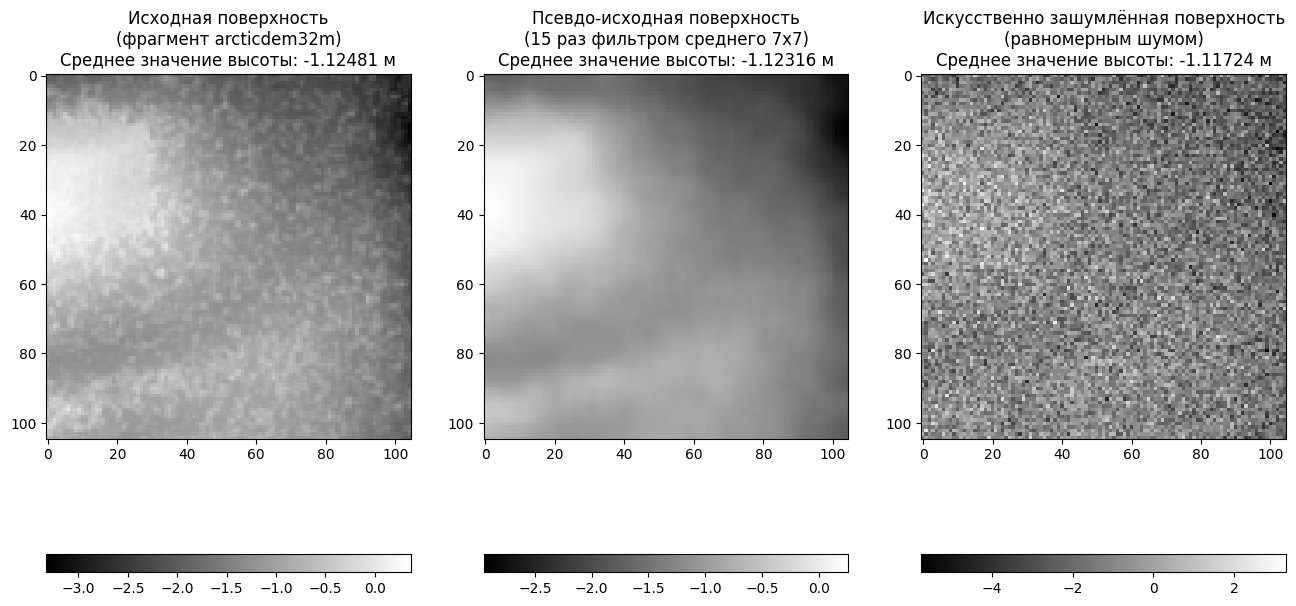

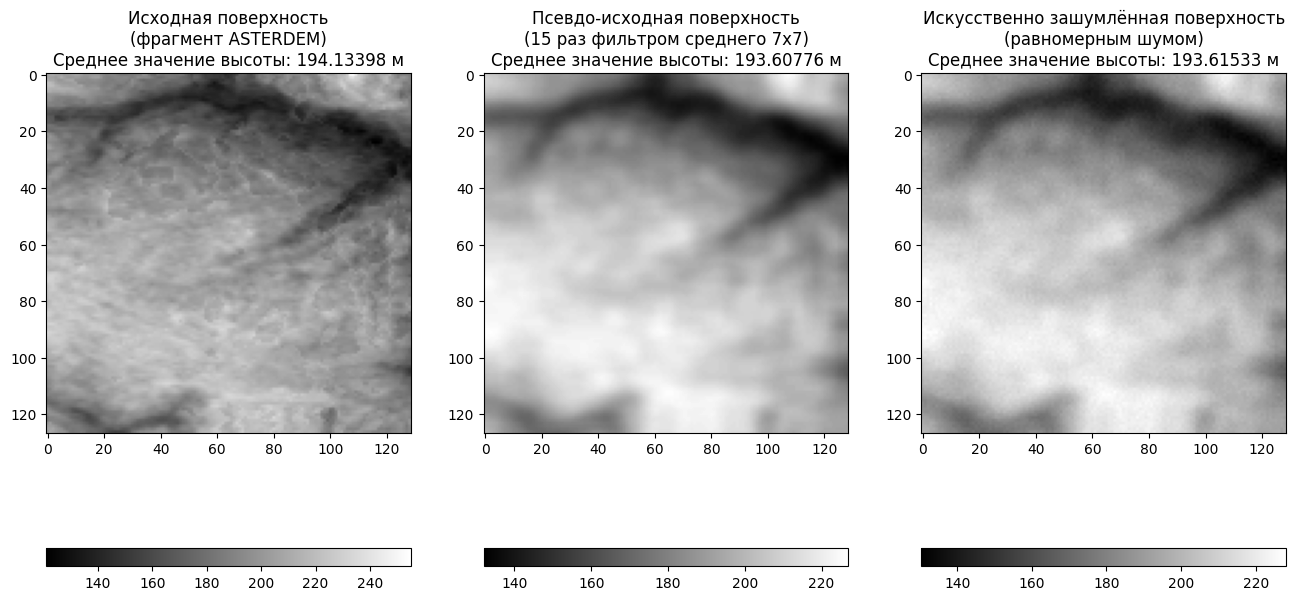

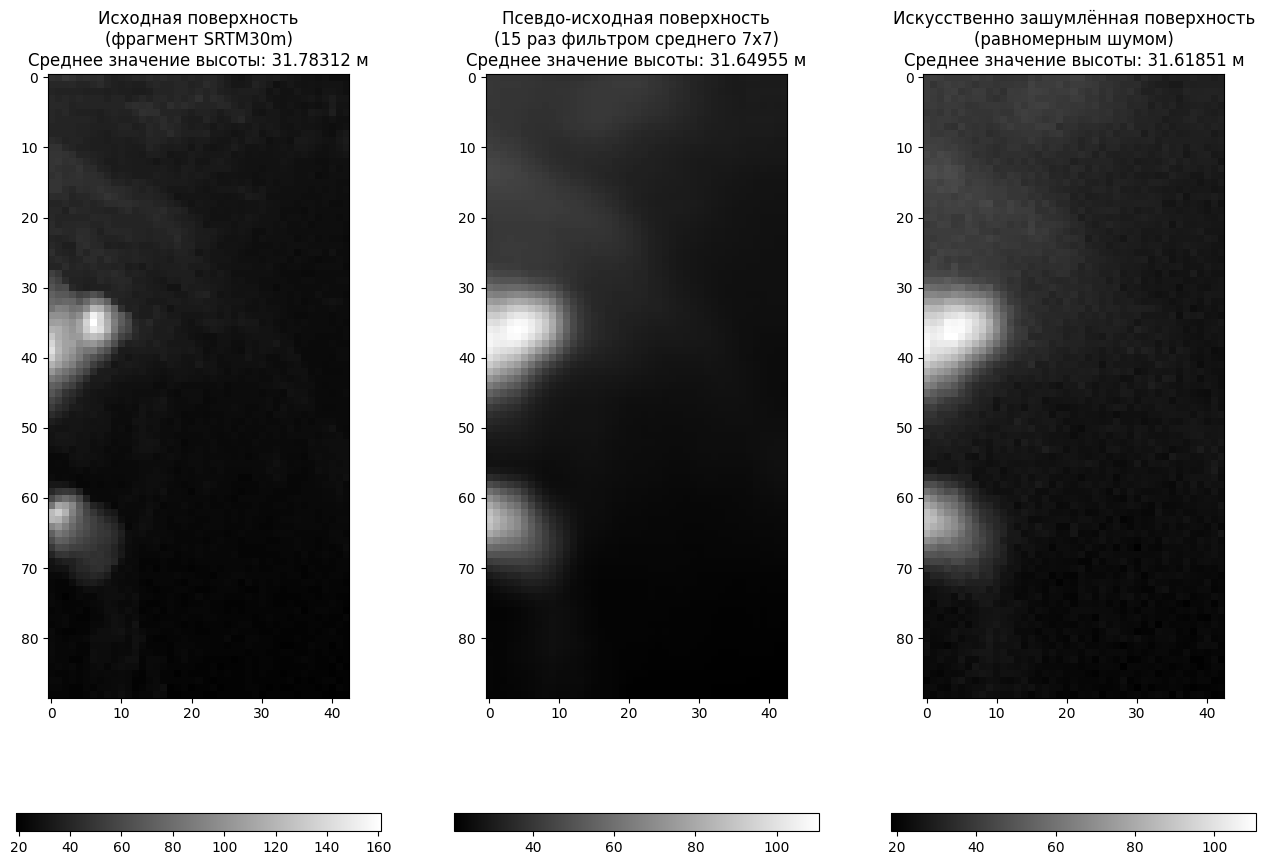

In [67]:
original_dems = ['arcticdem32m_Lena_original', 'ASTERDEM_Belgorod_original', 'SRTM30m_Kamchatka_original']
for original_dem in original_dems:
    original_file = r'D:\altsyplenkov\cw\ch3\\' + original_dem + '.tif'
    pseudo_original_file = r'D:\altsyplenkov\cw\ch3\\' + original_dem.split('_')[0] + '_' + original_dem.split('_')[1] + '_ps.tif'
    noisy_original_file = r'D:\altsyplenkov\cw\ch3\\' + original_dem.split('_')[0] + '_' + original_dem.split('_')[1] + '_noised.tif'

    with rasterio.open(original_file) as ds:
        original_dem_arr = ds.read()[0]
        shape = original_dem_arr.shape

    with rasterio.open(pseudo_original_file) as ds:
        ps_dem_arr = ds.read()[0]
        shape = ps_dem_arr.shape

    with rasterio.open(noisy_original_file) as ds:
        noisy_dem_arr = ds.read()[0]
        shape = noisy_dem_arr.shape

    fig = plt.figure(figsize=(16, 10))

    gdem = original_dem.split('_')[0]

    ax1 = fig.add_subplot(1, 3, 1)
    ax1.set_title(f'Исходная поверхность\n(фрагмент {gdem})\nСреднее значение высоты: {round(float(np.mean(original_dem_arr)), 5)} м')
    plt.imshow(original_dem_arr, cmap='binary_r')
    plt.colorbar(fraction=0.04, orientation='horizontal')
    
    ax2 = fig.add_subplot(1, 3, 2)
    ax2.set_title(f'Псевдо-исходная поверхность\n(15 раз фильтром среднего 7x7)\nСреднее значение высоты: {round(float(np.mean(ps_dem_arr)), 5)} м')
    plt.imshow(ps_dem_arr, cmap='binary_r')
    plt.colorbar(fraction=0.04, orientation='horizontal')

    ax3 = fig.add_subplot(1, 3, 3)
    ax3.set_title(f'Искусственно зашумлённая поверхность\n(равномерным шумом)\nСреднее значение высоты: {round(float(np.mean(noisy_dem_arr)), 5)} м')
    plt.imshow(noisy_dem_arr, cmap='binary_r')
    plt.colorbar(fraction=0.04, orientation='horizontal')

    plt.savefig(r'D:\altsyplenkov\cw\ch3\\'+f'3R_{gdem}' + '.png')



# Расчёт морфометрических величин

In [43]:
def Slope(input_dir):
    output_dir = r'D:\altsyplenkov\cw\surfaces\morpho\current_slope.tif'
    
    wbt.slope(
        dem = input_dir, 
        output = output_dir, 
        zfactor=None, 
        units="degrees"
    )

    with rasterio.open(output_dir, 'r') as ds:
        slope_data = ds.read()[0]
    
    return slope_data

In [44]:
def PlanCurvature(input_dir):
    output_dir = r'D:\altsyplenkov\cw\surfaces\morpho\current_hcurv.tif'
    
    wbt.plan_curvature(
        dem = input_dir, 
        output = output_dir, 
        log=False, 
        zfactor=None
    )

    with rasterio.open(output_dir, 'r') as ds:
        plan_curvature_data = ds.read()[0]
    
    return plan_curvature_data

In [45]:
def ProfileCurvature(input_dir):
    output_dir = r'D:\altsyplenkov\cw\surfaces\morpho\current_vcurv.tif'

    wbt.profile_curvature(
        dem = input_dir, 
        output = output_dir, 
        log=False, 
        zfactor=None
    )

    with rasterio.open(output_dir, 'r') as ds:
        profile_curvature_data = ds.read()[0]

    return profile_curvature_data

# Поиск оптимального алгоритма сглаживающей фильтрации:

In [53]:
start_time = time.time()

with open(r'D:\altsyplenkov\cw\ch3\real_surfaces_res.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=';')
    writer.writerow(['Название модели', 'Фильтр', 'Размер ячейки', 'Параметры',\
                     'Ср. значение высоты (исх.)', 'Ср. значение уклона (исх.)', 'Ср. значение hcurv (исх.)', 'Ср. значение vcurv (исх.)',\
                     'Ср. значения высоты (шум.)', 'Ср. значение уклона (шум.)', 'Ср. значение hcurv (шум.)', 'Ср. значение vcurv (шум.)',\
                     'Ср. значения высоты (фил.)', 'Ср. значения уклона (фил.)', 'Ср. значения hcurv (фил.)', 'Ср. значения vcurv (фил.)'])
    for original_dem in original_dems:
        original_file = r'D:\altsyplenkov\cw\ch3\\' + original_dem + '.tif'
        clear_dem = r'D:\altsyplenkov\cw\ch3\\' + original_dem.split('_')[0] + '_' + original_dem.split('_')[1] + '_ps.tif'
        noisy_dem = r'D:\altsyplenkov\cw\ch3\\' + original_dem.split('_')[0] + '_' + original_dem.split('_')[1] + '_noised.tif'

        gdem = original_dem.split('_')[0]
        
        with rasterio.open(clear_dem, 'r') as ds:
            data_clear = ds.read()[0]
        mean_elev_clear = np.mean(data_clear)
        mean_slope_clear = np.mean(Slope(clear_dem))
        mean_hcurv_clear = np.mean(PlanCurvature(clear_dem))
        mean_vcurv_clear = np.mean(ProfileCurvature(clear_dem))
    
        with rasterio.open(noisy_dem, 'r') as ds:
            data_noisy = ds.read()[0]
        mean_elev_noisy = np.mean(data_noisy)
        mean_slope_noisy = np.mean(Slope(noisy_dem))
        mean_hcurv_noisy = np.mean(PlanCurvature(noisy_dem))
        mean_vcurv_noisy = np.mean(ProfileCurvature(noisy_dem))

        #output_path = r'D:\altsyplenkov\cw\surfaces\REAL_filtered\current.tif'
        
        for kernel_size in [3, 5, 7, 11, 15]:
            output_path = r'C:\Users\administrator\abstract_surfaces_cr\surfaces\\' + gdem + '_Mean_' + str(kernel_size) + '.tif'
    
            wbt.mean_filter(noisy_dem, output_path, kernel_size, kernel_size)

            with rasterio.open(output_path, 'r') as ds:
                data_filtered = ds.read()[0]
            mean_elev_filtered = np.mean(data_filtered)
            mean_slope_filtered = np.mean(Slope(output_path))
            mean_hcurv_filtered = np.mean(PlanCurvature(output_path))
            mean_vcurv_filtered = np.mean(ProfileCurvature(output_path))

            writer.writerow([gdem, 'MeanFilter', kernel_size, '-',\
                            str(mean_elev_clear), str(mean_slope_clear), str(mean_hcurv_clear), str(mean_vcurv_clear),\
                            str(mean_elev_noisy), str(mean_slope_noisy), str(mean_hcurv_noisy), str(mean_vcurv_noisy),\
                            str(mean_elev_filtered), str(mean_slope_filtered), str(mean_hcurv_filtered), str(mean_vcurv_filtered)])

            output_path = r'C:\Users\administrator\abstract_surfaces_cr\surfaces\\' + gdem + '_Median_' + str(kernel_size) + '.tif'
            wbt.median_filter(noisy_dem, output_path, kernel_size, kernel_size)

            with rasterio.open(output_path, 'r') as ds:
                data_filtered = ds.read()[0]
            mean_elev_filtered = np.mean(data_filtered)
            mean_slope_filtered = np.mean(Slope(output_path))
            mean_hcurv_filtered = np.mean(PlanCurvature(output_path))
            mean_vcurv_filtered = np.mean(ProfileCurvature(output_path))
            
            writer.writerow([gdem, 'MedianFilter', kernel_size, None,\
                            str(mean_elev_clear), str(mean_slope_clear), str(mean_hcurv_clear), str(mean_vcurv_clear),\
                            str(mean_elev_noisy), str(mean_slope_noisy), str(mean_hcurv_noisy), str(mean_vcurv_noisy),\
                            str(mean_elev_filtered), str(mean_slope_filtered), str(mean_hcurv_filtered), str(mean_vcurv_filtered)])

            output_path = r'C:\Users\administrator\abstract_surfaces_cr\surfaces\\' + gdem + '_ConservativeSmoothing_' + str(kernel_size) + '.tif'
            
            wbt.conservative_smoothing_filter(noisy_dem, output_path, kernel_size, kernel_size)

            with rasterio.open(output_path, 'r') as ds:
                data_filtered = ds.read()[0]
            mean_elev_filtered = np.mean(data_filtered)
            mean_slope_filtered = np.mean(Slope(output_path))
            mean_hcurv_filtered = np.mean(PlanCurvature(output_path))
            mean_vcurv_filtered = np.mean(ProfileCurvature(output_path))
            
            writer.writerow([gdem, 'ConservativeSmoothingFilter', kernel_size, '-',\
                            str(mean_elev_clear), str(mean_slope_clear), str(mean_hcurv_clear), str(mean_vcurv_clear),\
                            str(mean_elev_noisy), str(mean_slope_noisy), str(mean_hcurv_noisy), str(mean_vcurv_noisy),\
                            str(mean_elev_filtered), str(mean_slope_filtered), str(mean_hcurv_filtered), str(mean_vcurv_filtered)])
            
            output_path = r'C:\Users\administrator\abstract_surfaces_cr\surfaces\\' + gdem + '_Majority_' + str(kernel_size) + '.tif'
            
            wbt.majority_filter(noisy_dem, output_path, kernel_size, kernel_size)

            with rasterio.open(output_path, 'r') as ds:
                data_filtered = ds.read()[0]
            mean_elev_filtered = np.mean(data_filtered)
            mean_slope_filtered = np.mean(Slope(output_path))
            mean_hcurv_filtered = np.mean(PlanCurvature(output_path))
            mean_vcurv_filtered = np.mean(ProfileCurvature(output_path))

            writer.writerow([gdem, 'MajorityFilter', kernel_size, '-',\
                            str(mean_elev_clear), str(mean_slope_clear), str(mean_hcurv_clear), str(mean_vcurv_clear),\
                            str(mean_elev_noisy), str(mean_slope_noisy), str(mean_hcurv_noisy), str(mean_vcurv_noisy),\
                            str(mean_elev_filtered), str(mean_slope_filtered), str(mean_hcurv_filtered), str(mean_vcurv_filtered)])

            output_path = r'C:\Users\administrator\abstract_surfaces_cr\surfaces\\' + gdem + '_Olympic_' + str(kernel_size) + '.tif'
            
            wbt.olympic_filter(noisy_dem, output_path, kernel_size, kernel_size)

            with rasterio.open(output_path, 'r') as ds:
                data_filtered = ds.read()[0]
            mean_elev_filtered = np.mean(data_filtered)
            mean_slope_filtered = np.mean(Slope(output_path))
            mean_hcurv_filtered = np.mean(PlanCurvature(output_path))
            mean_vcurv_filtered = np.mean(ProfileCurvature(output_path))

            writer.writerow([gdem, 'OlympicFilter', kernel_size, '-',\
                            str(mean_elev_clear), str(mean_slope_clear), str(mean_hcurv_clear), str(mean_vcurv_clear),\
                            str(mean_elev_noisy), str(mean_slope_noisy), str(mean_hcurv_noisy), str(mean_vcurv_noisy),\
                            str(mean_elev_filtered), str(mean_slope_filtered), str(mean_hcurv_filtered), str(mean_vcurv_filtered)])
                            
            for threshold in np.arange(0.1, 2.1, 0.1):
                threshold = round(threshold, 2)
                output_path = r'C:\Users\administrator\abstract_surfaces_cr\surfaces\\' + gdem + '_Adaptive_' + str(kernel_size) + str(threshold) +'.tif'
                
                wbt.adaptive_filter(noisy_dem, output_path, kernel_size, kernel_size, threshold)
                
                with rasterio.open(output_path, 'r') as ds:
                    data_filtered = ds.read()[0]
                mean_elev_filtered = np.mean(data_filtered)
                mean_slope_filtered = np.mean(Slope(output_path))
                mean_hcurv_filtered = np.mean(PlanCurvature(output_path))
                mean_vcurv_filtered = np.mean(ProfileCurvature(output_path))
                           
                writer.writerow([gdem, 'AdaptiveFilter', str(kernel_size), str(threshold),\
                            str(mean_elev_clear), str(mean_slope_clear), str(mean_hcurv_clear), str(mean_vcurv_clear),\
                            str(mean_elev_noisy), str(mean_slope_noisy), str(mean_hcurv_noisy), str(mean_vcurv_noisy),\
                            str(mean_elev_filtered), str(mean_slope_filtered), str(mean_hcurv_filtered), str(mean_vcurv_filtered)])

                output_path = r'C:\Users\administrator\abstract_surfaces_cr\surfaces\\' + gdem + '_EdgePreservingMean_' + str(kernel_size) + str(threshold) + '.tif'
                
                wbt.edge_preserving_mean_filter(noisy_dem, output_path, kernel_size, threshold)

                with rasterio.open(output_path, 'r') as ds:
                    data_filtered = ds.read()[0]
                mean_elev_filtered = np.mean(data_filtered)
                mean_slope_filtered = np.mean(Slope(output_path))
                mean_hcurv_filtered = np.mean(PlanCurvature(output_path))
                mean_vcurv_filtered = np.mean(ProfileCurvature(output_path))
                
                writer.writerow([gdem, 'EdgePreservingMeanFilter', str(kernel_size), str(threshold),\
                                str(mean_elev_clear), str(mean_slope_clear), str(mean_hcurv_clear), str(mean_vcurv_clear),\
                                str(mean_elev_noisy), str(mean_slope_noisy), str(mean_hcurv_noisy), str(mean_vcurv_noisy),\
                                str(mean_elev_filtered), str(mean_slope_filtered), str(mean_hcurv_filtered), str(mean_vcurv_filtered)])

            for norm_diff in [5]:
                for num_iter in range(2, 40):
                    max_diff = 2
                    output_path = r'C:\Users\administrator\abstract_surfaces_cr\surfaces\\' + gdem + '_FPDEMS_' + str(kernel_size)  + str(norm_diff) + f'_{str(num_iter)}_{str(max_diff)}' + '.tif'
                    
                    wbt.feature_preserving_smoothing(noisy_dem, output_path, kernel_size, norm_diff, num_iter, max_diff)

                    with rasterio.open(output_path, 'r') as ds:
                        data_filtered = ds.read()[0]
                    mean_elev_filtered = np.mean(data_filtered)
                    mean_slope_filtered = np.mean(Slope(output_path))
                    mean_hcurv_filtered = np.mean(PlanCurvature(output_path))
                    mean_vcurv_filtered = np.mean(ProfileCurvature(output_path))
                    
                    writer.writerow([gdem, 'FPDEMS', kernel_size, str([norm_diff, num_iter, max_diff]),\
                                    str(mean_elev_clear), str(mean_slope_clear), str(mean_hcurv_clear), str(mean_vcurv_clear),\
                                    str(mean_elev_noisy), str(mean_slope_noisy), str(mean_hcurv_noisy), str(mean_vcurv_noisy),\
                                    str(mean_elev_filtered), str(mean_slope_filtered), str(mean_hcurv_filtered), str(mean_vcurv_filtered)])

csvfile.close()

await send_telegram_message(f"Ячейка выполнена\! Время выполнения\: {int((time.time() - start_time) / 60)} минут")        
await send_file_to_telegram(r'D:\altsyplenkov\cw\ch3\real_surfaces_res.csv')